In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'fastai-v3/'

In [2]:
import pandas as pd

In [3]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [4]:
import random
import os
import numpy as np
import torch

def seed_everything(seed=69):
   random.seed(seed)
   os.environ['PYTHONHASHSEED'] = str(seed)
   np.random.seed(seed)
   torch.manual_seed(seed)
   torch.cuda.manual_seed(seed)
   torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai import *
from fastai.text import *

In [7]:
language = pd.read_csv('../input/final-language-data/final (1).csv')

In [8]:
# data.vocab.itos[:20]

## Language model

In [9]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/tmp/.fastai/data/imdb/tmp_clas'),
 PosixPath('/tmp/.fastai/data/imdb/README'),
 PosixPath('/tmp/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/tmp/.fastai/data/imdb/train'),
 PosixPath('/tmp/.fastai/data/imdb/unsup'),
 PosixPath('/tmp/.fastai/data/imdb/tmp_lm'),
 PosixPath('/tmp/.fastai/data/imdb/test')]

In [10]:
from sklearn.model_selection import train_test_split
# language, classification = train_test_split(t_reviews, test_size=0.4, random_state=69, shuffle=True, stratify=t_reviews['rating'])

In [11]:
language = language.reset_index()

In [12]:
for a in os.listdir('/tmp/.fastai/data/imdb/train/pos/')[:13000]:
    with open(f'/tmp/.fastai/data/imdb/train/pos/{a}', 'r') as file:
        data = file.read().replace('\n', '')
        dict1 = {'review': str(data), 'rating': str('pos')}
        language = language.append(dict1, ignore_index=True)
#         language.loc[7087+i]['review'] = data   

In [13]:
for a in os.listdir('/tmp/.fastai/data/imdb/train/neg/')[:9000]:
    with open(f'/tmp/.fastai/data/imdb/train/neg/{a}', 'r') as file:
        data = file.read().replace('\n', '')
        dict1 = {'review': str(data), 'rating': str('neg')}
        language = language.append(dict1, ignore_index=True)
#         language.loc[7087+i]['review'] = data   

In [14]:
language = language.drop('index', axis=1)
language.to_csv('../working/language.csv', index=False)

In [15]:
bs = 32
data_lm = (TextList.from_csv(path='../working',csv_name='language.csv', cols='review')
           #Inputs: all the text files in path
#             .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('../working/data_lm.pkl')

In [16]:
data_lm.show_batch()

idx,text
0,making that amazing fusion of xxmaj nacho xxmaj xxunk xxmaj chaat at xxmaj alchemy xxmaj bar on the rooftop . xxmaj chef xxmaj janet also was so kind and hospitable and she prepared the coolest pancakes for my daughter xxrep 4 . she said they were the best ever xxrep 4 . beat me to it xxmaj haha . xxmaj this hotel is close to everything . xxmaj definitely recommend
1,"the xxmaj lalit xxmaj mumbai is a great place to stay because of 2 reasons primarily . xxmaj first , xxmaj hospitality by its staff like xxmaj ruby , xxmaj rahul , xxmaj pramila , xxmaj vaibhav , xxmaj sangram , xxmaj vishal . xxmaj second , care taken by xxup f&b and xxmaj kitchen is amazing . xxmaj they make sure that they keep tab on your choices and"
2,". xxmaj amazing experience had there ... xxmaj one of the best hotel in lucknow xxrep 4 . xxmaj had a great tym xxrep 4 . xxmaj must visit once .. xxbos xxmaj the staff is amazing and the food is amazing the restaurant staff xxunk sharma was at the best of his xxunk and was very attentive and patient , its very rare to see such a staff after"
3,"payment again . xxmaj so in my eyes , i felt like i paid twice and at this point i had no clue what the hell was going on . xxmaj first i should be served first as i was there before the other 3 , second - i should be communicated with and third , the server should observe and communicate better as my credit card clearly was not"
4,"xxmaj timm xxmaj hill , xxmaj read xxmaj scot , xxmaj james xxmaj hogan , xxmaj derek xxmaj givens ... xxmaj director xxmaj james xxmaj xxunk ... xxmaj screenplay xxmaj sam xxmaj egan , xxmaj john xxmaj paragon . \n \n xxmaj elvira , xxmaj mistress of the xxmaj dark was an 80 's xxup tv icon who had her own late night show on cable . xxmaj she"


In [17]:
# data_lm = load_data(path, '../working/data_lm.pkl', bs=bs)

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [18]:
from fastai.callbacks import *
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, model_dir='../working/')

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


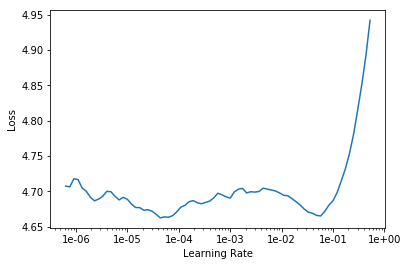

In [20]:
learn.recorder.plot(skip_end=15)

In [21]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.199586,4.052171,0.288776,04:30


In [22]:
learn.save('fit_head')

In [23]:
learn.load('fit_head');

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(10, 1e-3/2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.850243,3.924560,0.300979,05:20
1,3.825099,3.863237,0.308523,05:18
2,3.778350,3.829984,0.313242,05:18
3,3.668321,3.811476,0.316284,05:22
4,3.560770,3.802444,0.319024,05:19
5,3.487836,3.802206,0.319374,05:17
6,3.416113,3.810034,0.319867,05:18
7,3.306204,3.820594,0.319894,05:19


In [26]:
learn.save('fine_tuned')

In [27]:
# learn.load('fine_tuned');

In [28]:
# TEXT = "I liked this movie because"
# N_WORDS = 40
# N_SENTENCES = 2

In [29]:
# print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [30]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [31]:
path = untar_data(URLs.IMDB)

In [32]:
# classification = classification.reset_index()
# classification = classification.drop('index', axis=1)
# classification.to_csv('../working/classification.csv', index=False)

In [33]:
# for a in os.listdir('/tmp/.fastai/data/imdb/test/pos/')[:7000]:
#     with open(f'/tmp/.fastai/data/imdb/test/pos/{a}', 'r') as file:
#         data = file.read().replace('\n', '')
#         dict1 = {'review': str(data), 'rating': str('pos')}
#         classification = classification.append(dict1, ignore_index=True)
# #         language.loc[7087+i]['review'] = data   

In [34]:
# for a in os.listdir('/tmp/.fastai/data/imdb/train/neg/')[7000:10000]:
#     with open(f'/tmp/.fastai/data/imdb/train/neg/{a}', 'r') as file:
#         data = file.read().replace('\n', '')
#         dict1 = {'review': str(data), 'rating': str('neg')}
#         classification = classification.append(dict1, ignore_index=True)
# #         language.loc[7087+i]['review'] = data   

In [35]:
bs = 32
data_clas = (TextList.from_csv('../working', 'language.csv', vocab=data_lm.train_ds.vocab, cols='review')
                   .split_by_rand_pct(0.1)
                   .label_from_df(cols='rating')
                   .databunch(bs=bs))
data_clas.save('../working/data_lm.pkl')

# data_lm = (TextList.from_csv(path='../working',csv_name='language.csv', cols='review')
#            #Inputs: all the text files in path
# #             .filter_by_folder(include=['train', 'test', 'unsup']) 
#            #We may have other temp folders that contain text files so we only keep what's in train and test
#             .split_by_rand_pct(0.1)
#            #We randomly split and keep 10% (10,000 reviews) for validation
#             .label_for_lm()           
#            #We want to do a language model so we label accordingly
#             .databunch(bs=bs))

In [36]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n \n xxmaj this xxmaj serial is one of my own personal favourites , and as previously stated , it is one of the xxmaj top 5 xxmaj sound xxmaj serials . xxmaj oddly enough , this",pos
"xxbos "" xxmaj fever xxmaj pitch "" is n't a bad film ; it 's a terrible film . \n \n xxmaj is it possible xxmaj american movie audiences and critics are so numbed and lobotomized by the excrement that xxmaj hollywood churns out that they 'll praise to the skies even a mediocre film with barely any laughs ? xxmaj that 's the only reason i can think",neg
"xxbos xxmaj after reading the previous comments , i 'm just glad that i was n't the only person left confused , especially by the last 20 minutes . xxmaj john xxmaj carradine is shown twice walking down into a grave and pulling the lid shut after him . i anxiously awaited some kind of explanation for this odd behavior ... naturally i assumed he had something to do with",neg
"xxbos i figured that it 's about time i let this one out . xxmaj pokémon fans are suffering in xxmaj america these days . xxmaj why ? xxmaj because we rely on xxmaj kids xxup wb and 4kids xxmaj entertainment to provide us with our beloved series and movies . xxmaj as far as the series goes , they do a pretty good job in bringing the fun and",neg


We can then create a model to classify those reviews and load the encoder we saved before.

In [37]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, model_dir='../working/')
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (29982 items)
x: TextList
xxbos xxmaj loved the stay at the hotel . xxmaj they upgraded our room to a nice pool facing club room . xxmaj food was amazing . xxmaj breakfast spread tooo good . xxmaj pool is fantastic . xxmaj alchemy bar rocking . xxmaj staff took kind n hospitable including xxunk xxmaj xxunk and xxmaj xxunk ... such nice people . xxmaj and chef xxmaj jackson xxunk was soo cool making that amazing fusion of xxmaj nacho xxmaj xxunk xxmaj chaat at xxmaj alchemy xxmaj bar on the rooftop . xxmaj chef xxmaj janet also was so kind and hospitable and she prepared the coolest pancakes for my daughter xxrep 4 . she said they were the best ever xxrep 4 . beat me to it xxmaj haha . xxmaj this hotel is close to everything . xxmaj definitely recommend this hotel .,xxbos xxmaj good , quick service . xxmaj floor manager xxmaj xxunk is very efficient . xxmaj akash , from housekeeping , is also worth mentioning . xxmaj good location , r

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


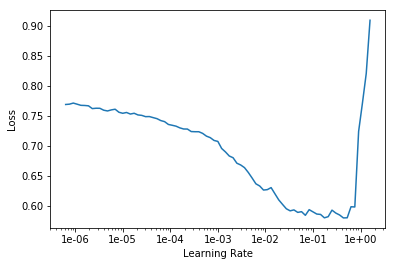

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.362135,0.253638,0.901531,01:48


In [41]:
learn.save('first')

In [42]:
learn.load('first');

In [43]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.251374,0.193439,0.920444,02:28


In [44]:
learn.save('second')

In [45]:
learn.load('second');

In [46]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.209334,0.163441,0.934554,03:33


In [47]:
learn.save('third')

In [48]:
learn.load('third');

In [49]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.175033,0.152788,0.937256,04:59
1,0.158975,0.158021,0.939057,03:40


In [50]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([0.0013, 0.9987]))